# Counting Rings in Cropped Images - (New)Fake Data

The newer version of the fake data has a uniform distribution of non-integer ring counts.  Style matching with the real data done "a bit" via bandpass mixup. 

In [ ]:
#all_slow

In [ ]:
#hide
#Run once per session
!pip install fastai espiownage -q --upgrade
import espiownage
print(f"espiownage version {espiownage.__version__}")

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
espiownage version 0.0.38


And import our libraries

In [ ]:
from fastai.vision.all import *
from espiownage.core import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.foundation import L
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.data.external import untar_data, URLs

from fastai.data.block import RegressionBlock, DataBlock
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, parent_label

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`
from fastai.optimizer import ranger

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner
from fastai.vision.utils import download_images, verify_images

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
print("hostname:")
!hostname

1.9.0+cu111
True
1
0
GeForce RTX 3080
hostname:
bengio


In [ ]:
path = Path('/home/shawley/datasets/espiownage-fake/crops')

# cyclegan fake data is public, for demo & reproducibility:  add force_download=True to grab a new version if needed
#path = untar_data('http://hedges.belmont.edu/~shawley/espiownage-cyclegan.tgz') / 'crops'
print(path)

/home/shawley/datasets/espiownage-fake/crops


In [ ]:
fnames = get_image_files(path)
print(f"{len(fnames)} total cropped images")
ind = 1  # pick one cropped image
fnames[ind]

6923 total cropped images


Path('/home/shawley/datasets/espiownage-fake/crops/steelpan_0000097_15_64_200_175_9.4.png')

For labels, we want the ring count which is the number between the last '_' and the '.png'

In [ ]:
def label_func(x):  
    return round(float(x.stem.split('_')[-1]),2)

print(label_func(fnames[ind]))

9.4


In [ ]:
cropsize = (300,300) # pixels
croppedrings = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=1)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=label_func,
                   item_tfms=Resize(cropsize, ResizeMethod.Squish),
                   batch_tfms=[*aug_transforms(size=cropsize, flip_vert=True, max_rotate=360.0), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = croppedrings.dataloaders(path, bs=32)

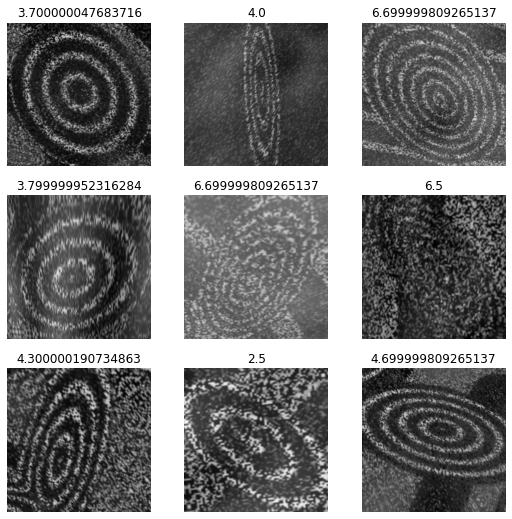

In [ ]:
dls.show_batch(max_n=9)

## Train model

In [ ]:
opt = ranger

In [ ]:
#PETS example learner:learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=MSELossFlat(), n_out=1, y_range=(0,11), opt_func=opt)#.to_fp16()

y_range=(0.5,11.5)  # try to stay in the semi-linear range of the sigmoid; our values are 1 to 11. 
learn = cnn_learner(dls, resnet34, n_out=1, y_range=y_range, metrics=[mae, acc_reg05,acc_reg1,acc_reg15,acc_reg2], loss_func=MSELossFlat(), opt_func=opt)

/home/shawley/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.0030199517495930195)

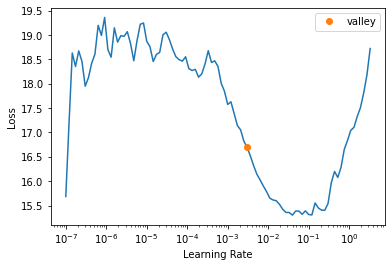

In [ ]:
learn.lr_find()

In [ ]:
#learn.fine_tune(10, 1e-2)
learn.fine_tune(20, 5e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg1,acc_reg15,acc_reg2,time
0,9.762798,5.984264,1.982502,0.147399,0.295520,0.433526,0.571532,00:18
1,5.274107,1.694514,0.989821,0.324422,0.606214,0.799133,0.892341,00:18


epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg1,acc_reg15,acc_reg2,time
0,2.253992,0.736749,0.646434,0.494942,0.793353,0.932081,0.971821,00:22
1,1.351375,0.551237,0.546193,0.565029,0.872110,0.961705,0.982659,00:22
2,0.897313,0.351825,0.441811,0.661127,0.930636,0.984104,0.992775,00:22
3,0.815058,1.089316,0.899519,0.253613,0.572254,0.890173,0.981214,00:22
4,0.783441,0.370135,0.466272,0.619942,0.911850,0.980491,0.993497,00:22
5,0.781135,0.193379,0.323769,0.794798,0.973266,0.994220,0.998555,00:22
6,0.688564,0.449081,0.491218,0.638006,0.872832,0.963873,0.988439,00:22
7,0.521358,0.286659,0.415029,0.677023,0.940751,0.986994,0.997832,00:22
8,0.594988,0.761670,0.605184,0.598266,0.821532,0.907514,0.951590,00:22
9,0.408119,0.815854,0.758213,0.358382,0.713150,0.918353,0.984827,00:22


In [ ]:
learn.save('crop-rings-fake2')

Path('models/crop-rings-fake2.pth')

## Interpretation

In [ ]:
learn.load('crop-rings-fake2');

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True) # validation set only
len(preds)

1384

I'll define a method to show a single prediction

In [ ]:
def showpred(ind, preds, targs, losses, dls): # show prediction at this index
    print(f"preds[{ind}] = {preds[ind]}, targs[{ind}] = {targs[ind]}, loss = {losses[ind]}")
    print(f"file = {dls.valid.items[ind]}")
    print("Image:")
    dls.valid.dataset[ind][0].show()

preds[0] = tensor([6.9781]), targs[0] = 7.0, loss = 0.0004809135280083865
file = /home/shawley/datasets/espiownage-fake/crops/steelpan_0001854_115_255_248_360_7.0.png
Image:


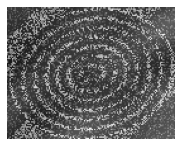

In [ ]:
showpred(0, preds, targs, losses, dls)

And now we'll run through predictions for the whole validation set:

In [ ]:
#preds, targs, losses = learn.get_preds(with_loss=True)
results = []
for i in range(len(preds)):
    line_list = [dls.valid.items[i].stem]+[round(targs[i].cpu().numpy().item(),2), round(preds[i][0].cpu().numpy().item(),2), losses[i].cpu().numpy(), i]
    results.append(line_list)

# store as pandas dataframe
res_df = pd.DataFrame(results, columns=['filename', 'target', 'prediction', 'loss','i'])

We can do our own version of printing top_losses:

In [ ]:
res_df = res_df.sort_values('loss', ascending=False)
res_df.head()

,filename,target,prediction,loss,i
1150,steelpan_0000740_277_77_342_154_5.0,5.0,6.19,1.4271662,1150
1009,steelpan_0000704_135_279_378_384_3.8,3.8,2.75,1.098972,1009
277,steelpan_0000441_167_164_348_384_7.0,7.0,5.97,1.0530723,277
76,steelpan_0000123_22_70_93_141_5.3,5.3,6.28,0.9678764,76
1056,steelpan_0000602_167_310_232_367_6.2,6.2,7.13,0.86024874,1056


preds[1150] = tensor([6.1946]), targs[1150] = 5.0, loss = 1.427166223526001
file = /home/shawley/datasets/espiownage-fake/crops/steelpan_0000740_277_77_342_154_5.0.png
Image:
preds[1009] = tensor([2.7517]), targs[1009] = 3.799999952316284, loss = 1.098971962928772
file = /home/shawley/datasets/espiownage-fake/crops/steelpan_0000704_135_279_378_384_3.8.png
Image:
preds[277] = tensor([5.9738]), targs[277] = 7.0, loss = 1.0530723333358765
file = /home/shawley/datasets/espiownage-fake/crops/steelpan_0000441_167_164_348_384_7.0.png
Image:
preds[76] = tensor([6.2838]), targs[76] = 5.300000190734863, loss = 0.9678763747215271
file = /home/shawley/datasets/espiownage-fake/crops/steelpan_0000123_22_70_93_141_5.3.png
Image:
preds[1056] = tensor([7.1275]), targs[1056] = 6.199999809265137, loss = 0.8602487444877625
file = /home/shawley/datasets/espiownage-fake/crops/steelpan_0000602_167_310_232_367_6.2.png
Image:


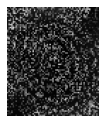

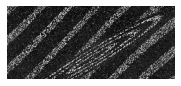

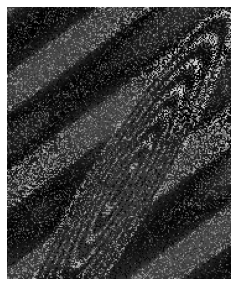

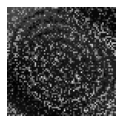

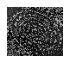

In [ ]:
def show_top_losses(res_df, preds, targs, losses, dls, n=5):
    for j in range(n):
        showpred(res_df.iloc[j]['i'], preds, targs, losses, dls)
        
show_top_losses(res_df, preds, targs, losses, dls)

In [ ]:
res_df.to_csv('ring_count_top_losses_fake2.csv', index=False)

## When in doubt, LOOK AT THE DATA
Let's take a look at plots of this data

In [ ]:
df2 = res_df.reset_index(drop=True)

Text(0, 0.5, 'Ring count')

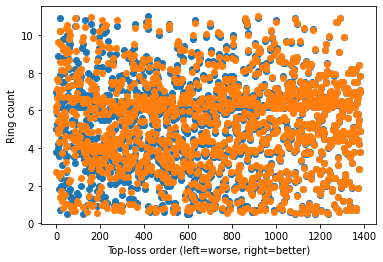

In [ ]:
plt.plot(df2["target"],'o')
plt.plot(df2["prediction"],'o')
plt.xlabel('Top-loss order (left=worse, right=better)')
plt.ylabel('Ring count')

(-0.025000000000000022, 11.525, 0.00649999999999995, 11.5565)

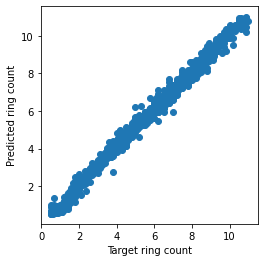

In [ ]:
plt.plot(df2["target"],df2["prediction"],'o')
plt.xlabel('Target ring count')
plt.ylabel('Predicted ring count')
plt.axis('square')

In [ ]:
print(f"Target ring count range: ({df2['target'].min()}, {df2['target'].max()})")
print(f"Predicted ring count range: ({df2['prediction'].min()}, {df2['prediction'].max()})")

Target ring count range: (0.5, 11.0)
Predicted ring count range: (0.53, 11.0)
